In [1]:
import cv2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pickle
import os
import csv
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

2023-10-19 08:12:11.933730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Adding CSV logger

In [73]:
class CSVLogger:
    def __init__(self, filename, fieldnames):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create and initialize the CSV file
        if not os.path.isfile(self.filename):
            with open(self.filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
                writer.writeheader()
        else:
            with open(self.filename, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
                writer.writerow({})

    def log(self, data):
        # Append data to the CSV file
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow(data)

Augmenting new images for "Moderate Demented" class

In [ ]:
# Define the path to your "Moderate demented" images
moderate_demented_dir = 'Alzheimer_s Dataset/train/ModerateDemented'

# Create a directory to save the augmented images
augmented_dir = 'Alzheimer_s Dataset/augmented/ModerateDemented'
os.makedirs(augmented_dir, exist_ok=True)

# Initialize the ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rescale=128./255,                # Rescale pixel values to [0, 1]
    brightness_range=[0.5, 1.5],  # Random brightness adjustment
    zoom_range=[0.8, 1.2],        # Random zooming
    fill_mode='nearest',          # Fill mode for filling pixels after augmentation
    horizontal_flip=True          # Random horizontal flipping
)

# List all images in the "Moderate demented" directory
image_files = os.listdir(moderate_demented_dir)

# Set the target number of augmented images (e.g., 700)
target_count = 256

# Loop until the target count is reached
generated_count = 0
while generated_count < target_count:
    # Randomly select an image from the original dataset
    image_file = np.random.choice(image_files)
    image_path = os.path.join(moderate_demented_dir, image_file)

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure it's in RGB format

    # Generate augmented images using the data generator
    aug_iter = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
    augmented_images = [next(aug_iter)[0].astype(np.uint8) for _ in range(5)]  # Create 5 augmented images per original

    # Save the augmented images
    for i, aug_image in enumerate(augmented_images):
        aug_filename = f'augmented_{generated_count + i}.jpg'
        aug_image_path = os.path.join(augmented_dir, aug_filename)
        cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

    # Update the count of generated images
    generated_count += len(augmented_images)

print(f'Generated {generated_count} augmented images.')

Arranging for binaryClassification

In [2]:
import shutil

def save_files_from_directories(dir_list, destination_dir):
    """
    Save files from a list of directories to a destination directory,
    avoiding naming clashes by renaming each file based on a counter.
    
    Args:
    dir_list (list): List of directory paths containing files to be saved.
    destination_dir (str): Destination directory where files will be saved.
    
    Returns:
    None
    """
    counter = 1  # Initialize a counter to rename files
    
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)
    
    # Iterate through each directory in the list
    for source_dir in dir_list:
        # Check if the source directory exists
        if os.path.exists(source_dir) and os.path.isdir(source_dir):
            # Iterate through files in the source directory
            for filename in os.listdir(source_dir):
                source_file_path = os.path.join(source_dir, filename)
                
                # Check if it's a file (not a directory)
                if os.path.isfile(source_file_path):
                    # Extract the file extension
                    _, file_extension = os.path.splitext(filename)
                    
                    # Create a new filename with a counter and the original extension
                    new_filename = f"file_{counter}{file_extension}"
                    counter += 1
                    
                    # Construct the destination file path
                    destination_file_path = os.path.join(destination_dir, new_filename)
                    
                    # Copy the file to the destination with the new name
                    shutil.copyfile(source_file_path, destination_file_path)
        else:
            print(f"Source directory '{source_dir}' does not exist or is not a directory.")
    
    print(f"Files saved to '{destination_dir}'.")

source_directories = ['Alzheimer_s Dataset/train/MildDemented', 'Alzheimer_s Dataset/train/ModerateDemented','Alzheimer_s Dataset/train/VeryMildDemented',
                      'Alzheimer_s Dataset/augmented/ModerateDemented','Alzheimer_s Dataset/test/MildDemented','Alzheimer_s Dataset/test/ModerateDemented',
                      'Alzheimer_s Dataset/test/VeryMildDemented']
destination_directory = 'Alzheimer_s Dataset/binaryClassification/all/Demented'
save_files_from_directories(source_directories, destination_directory)

source_directories = ['Alzheimer_s Dataset/train/NonDemented','Alzheimer_s Dataset/test/NonDemented']
destination_directory = 'Alzheimer_s Dataset/binaryClassification/all/NonDemented'
save_files_from_directories(source_directories, destination_directory)


Train-test-val split

In [8]:
# Define the source folder containing subfolders for each class
source_folder = 'Alzheimer_s Dataset/binaryClassification/all'
train_folder = 'Alzheimer_s Dataset/binaryClassification/train'
test_folder = 'Alzheimer_s Dataset/binaryClassification/test'
val_folder = 'Alzheimer_s Dataset/binaryClassification/val'

# Define the ratios for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List subfolders (classes) in the source folder
classes = os.listdir(source_folder)

# Loop through each class
for class_name in classes:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_test_folder = os.path.join(test_folder, class_name)
    class_val_folder = os.path.join(val_folder, class_name)

    # List image files in the class source folder
    image_files = os.listdir(class_source_folder)
    random.shuffle(image_files)

    # Calculate the number of images for each set based on the defined ratios
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    test_split = int(total_images * test_ratio)

    # Copy image files to their respective folders for train, test, and validation
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_source_folder, image_file)
        if i < train_split:
            destination_folder = class_train_folder
        elif i < train_split + test_split:
            destination_folder = class_test_folder
        else:
            destination_folder = class_val_folder

        destination_path = os.path.join(destination_folder, image_file)
        shutil.copyfile(source_path, destination_path)

Loading the dataset

In [7]:
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

train_generator = datagen.flow_from_directory(
    'Alzheimer_s Dataset/binaryClassification/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    'Alzheimer_s Dataset/binaryClassification/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    'Alzheimer_s Dataset/binaryClassification/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

classes = 2

Found 4662 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


Preparing model

In [4]:
# learning_rate = 0.00001
# patch_size = (3,3)
# num_hidden_units = 150 


# model = Sequential()
# model.add(Input(shape=(150, 150, 3))) # Added this
# model.add(Conv2D(32, patch_size, activation='relu', input_shape=(150, 150, 3))) # Changed 32 to 64
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(32, patch_size, activation='relu')) # Changed 32 to 64
# model.add(MaxPooling2D(2, 2))
# model.add(Flatten())
# model.add(Dense(num_hidden_units, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Number of classes


# # Compile and train model
# optimizer = tf.keras.optimizers.Adam()

# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.summary()

model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
                                                                                          
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())  
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Create model 
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 43808)             0         
                                                                 
 dense_2 (Dense)             (None, 150)              

Adding early stopping

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode="min")

Training model

In [8]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator,batch_size=32,callbacks=[callback])

Epoch 1/100


2023-10-10 15:22:52.346480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-10-10 15:22:52.630946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-10 15:22:52.683442: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f23c0e37f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 15:22:52.683466: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-10 15:22:52.686572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 15:22:52.701136: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This ma

  1/146 [..............................] - ETA: 4:47 - loss: 0.7013 - accuracy: 0.3438

2023-10-10 15:22:53.647911: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 668.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


146/146 [==============================] - 7s 35ms/step - loss: 0.6481 - accuracy: 0.6532 - val_loss: 0.5233 - val_accuracy: 0.7207
Epoch 2/100
146/146 [==============================] - 3s 21ms/step - loss: 0.4555 - accuracy: 0.7840 - val_loss: 0.3954 - val_accuracy: 0.8248
Epoch 3/100
146/146 [==============================] - 3s 19ms/step - loss: 0.2878 - accuracy: 0.8799 - val_loss: 0.2620 - val_accuracy: 0.8829
Epoch 4/100
146/146 [==============================] - 3s 20ms/step - loss: 0.1608 - accuracy: 0.9395 - val_loss: 0.1992 - val_accuracy: 0.9299
Epoch 5/100
146/146 [==============================] - 3s 19ms/step - loss: 0.0779 - accuracy: 0.9747 - val_loss: 0.1473 - val_accuracy: 0.9510
Epoch 6/100
146/146 [==============================] - 3s 19ms/step - loss: 0.0390 - accuracy: 0.9888 - val_loss: 0.1616 - val_accuracy: 0.9439
Epoch 7/100
146/146 [==============================] - 4s 29ms/step - loss: 0.0199 - accuracy: 0.9968 - val_loss: 0.1343 - val_accuracy: 0.9620
Epoc

Calculating accuracy

In [9]:
accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy[1])

32/32 [==============================] - 1s 26ms/step - loss: 0.0406 - accuracy: 0.9870
Test Accuracy: 0.9869869947433472


Plotting model accuracy

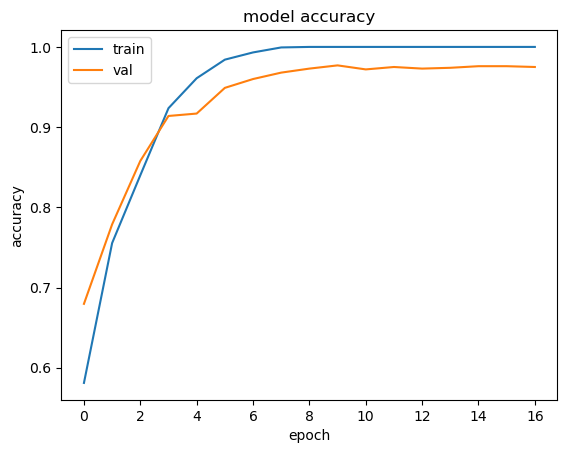

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Plotting loss function

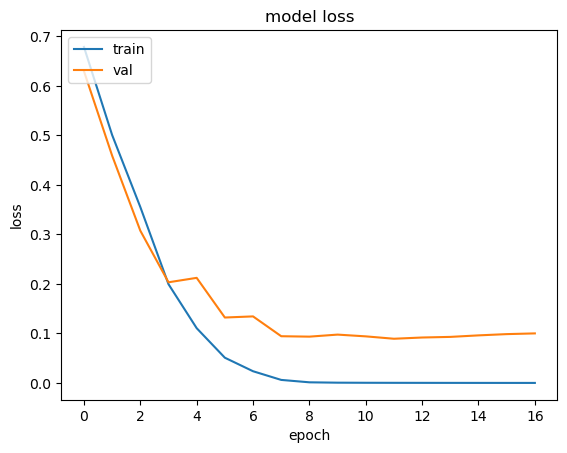

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Exporting model

In [ ]:
model.save('98.4acc.keras')

Preparing data for multi-classification

In [3]:
source_directories = ['Alzheimer_s Dataset/train/MildDemented',
                      'Alzheimer_s Dataset/test/MildDemented']
destination_directory = 'Alzheimer_s Dataset/multiClassification/all/MildDemented'
save_files_from_directories(source_directories, destination_directory)

source_directories = ['Alzheimer_s Dataset/train/ModerateDemented','Alzheimer_s Dataset/augmented/ModerateDemented','Alzheimer_s Dataset/test/ModerateDemented',]
destination_directory = 'Alzheimer_s Dataset/multiClassification/all/ModerateDemented'
save_files_from_directories(source_directories,destination_directory)

source_directories = ['Alzheimer_s Dataset/test/VeryMildDemented','Alzheimer_s Dataset/train/VeryMildDemented']
destination_directory = 'Alzheimer_s Dataset/multiClassification/all/VeryMildDemented'
save_files_from_directories(source_directories, destination_directory)


source_directories = ['Alzheimer_s Dataset/train/NonDemented','Alzheimer_s Dataset/test/NonDemented']
destination_directory = 'Alzheimer_s Dataset/multiClassification/all/NonDemented'
save_files_from_directories(source_directories, destination_directory)


Files saved to 'Alzheimer_s Dataset/multiClassification/all/MildDemented'.
Files saved to 'Alzheimer_s Dataset/multiClassification/all/ModerateDemented'.
Files saved to 'Alzheimer_s Dataset/multiClassification/all/VeryMildDemented'.
Files saved to 'Alzheimer_s Dataset/multiClassification/all/NonDemented'.


In [10]:
# Define the source folder containing subfolders for each class
source_folder = 'Alzheimer_s Dataset/multiClassification/all'
train_folder = 'Alzheimer_s Dataset/multiClassification/train'
test_folder = 'Alzheimer_s Dataset/multiClassification/test'
val_folder = 'Alzheimer_s Dataset/multiClassification/val'

# Define the ratios for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List subfolders (classes) in the source folder
classes = os.listdir(source_folder)

# Loop through each class
for class_name in classes:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_test_folder = os.path.join(test_folder, class_name)
    class_val_folder = os.path.join(val_folder, class_name)

    # List image files in the class source folder
    image_files = os.listdir(class_source_folder)
    random.shuffle(image_files)

    # Calculate the number of images for each set based on the defined ratios
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    test_split = int(total_images * test_ratio)

    # Copy image files to their respective folders for train, test, and validation
    for i, image_file in enumerate(image_files):
        source_path = os.path.join(class_source_folder, image_file)
        if i < train_split:
            destination_folder = class_train_folder
        elif i < train_split + test_split:
            destination_folder = class_test_folder
        else:
            destination_folder = class_val_folder

        destination_path = os.path.join(destination_folder, image_file)
        shutil.copyfile(source_path, destination_path)

Loading Dataset

In [2]:
# datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

# train_generator = datagen.flow_from_directory(
#     'Alzheimer_s Dataset/multiClassification/train',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='categorical'
# )

# validation_generator = datagen.flow_from_directory(
#     'Alzheimer_s Dataset/multiClassification/val',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='categorical'
# )

# test_generator = datagen.flow_from_directory(
#     'Alzheimer_s Dataset/multiClassification/test',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='categorical'
# )
tf.data.experimental.enable_debug_mode()

seed_train_validation = 1337 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0

train_ds = tf.keras.utils.image_dataset_from_directory(
directory ='Alzheimer_s Dataset/multiClassification/train',
image_size = (150,150),
validation_split = validation_split,
label_mode='categorical',
seed = seed_train_validation,
color_mode = 'rgb',
batch_size=50,
shuffle = shuffle_value)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory ='Alzheimer_s Dataset/multiClassification/test',
image_size = (150,150),
validation_split = validation_split,
seed = seed_train_validation,
batch_size=50,
color_mode = 'rgb',
label_mode='categorical',
shuffle = shuffle_value)

# val_batches = tf.data.experimental.cardinality(val_ds)
# test_ds = val_ds.take((1*val_batches) // 2)
# val_ds = val_ds.skip((1*val_batches) // 2)

# print(len(test_ds))
print(len(val_ds))
print(len(train_ds))

classes = 4

Found 5405 files belonging to 4 classes.
Found 1450 files belonging to 4 classes.
29
109


2023-10-17 11:51:05.055860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-17 11:51:06.273443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-17 11:51:06.273780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-17 11:51:06.274573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Preparing model

In [15]:
learning_rate = 0.001
patch_size = (3,3)
num_hidden_units = 150


model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, patch_size, activation='softplus',padding='same', input_shape=(150, 150, 3))) # Changed 32 to 64
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, patch_size, padding='same',activation='softplus')) # Changed 32 to 64
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(num_hidden_units, activation='softplus'))
model.add(Dense(classes, activation='softmax'))  # Number of classes


# Compile and train model
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 43808)             0         
                                                                 
 dense_8 (Dense)             (None, 150)              

Adding Early stopping

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode="min")
# logger = tf.keras.callbacks.CSVLogger('multiClassTrainLog.csv', separator=",", append=True)

Training model

In [16]:
tf.config.run_functions_eagerly(True)
history = model.fit(train_ds, epochs=100, validation_data=val_ds,batch_size=32,callbacks=[callback])

Epoch 1/100


109/109 [==============================] - 19s 170ms/step - loss: 34.9605 - accuracy: 0.4860 - val_loss: 1.0063 - val_accuracy: 0.5752
Epoch 2/100
109/109 [==============================] - 18s 160ms/step - loss: 0.7675 - accuracy: 0.6574 - val_loss: 0.6034 - val_accuracy: 0.7338
Epoch 3/100
109/109 [==============================] - 17s 151ms/step - loss: 0.4110 - accuracy: 0.8294 - val_loss: 0.3123 - val_accuracy: 0.8917
Epoch 4/100
109/109 [==============================] - 17s 151ms/step - loss: 0.2835 - accuracy: 0.8875 - val_loss: 0.1929 - val_accuracy: 0.9366
Epoch 5/100
109/109 [==============================] - 17s 152ms/step - loss: 0.1386 - accuracy: 0.9502 - val_loss: 0.1305 - val_accuracy: 0.9552
Epoch 6/100
109/109 [==============================] - 17s 151ms/step - loss: 0.0593 - accuracy: 0.9824 - val_loss: 0.0913 - val_accuracy: 0.9697
Epoch 7/100
109/109 [==============================] - 17s 152ms/step - loss: 0.0329 - accuracy: 0.9913 - val_loss: 0.0982 - val_accura

Calculating accuracy

In [17]:
accuracy = model.evaluate(val_ds)
print("Test Accuracy:", accuracy[1])
# Saving it
with open('./98.5accModelAccuracy.pkl', 'wb') as file_pi:
    pickle.dump(accuracy, file_pi)

29/29 [==============================] - 3s 73ms/step - loss: 0.0388 - accuracy: 0.9848
Test Accuracy: 0.9848275780677795


Saving history

In [90]:
with open('./98.5accModelHistory.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Plotting model accuracy

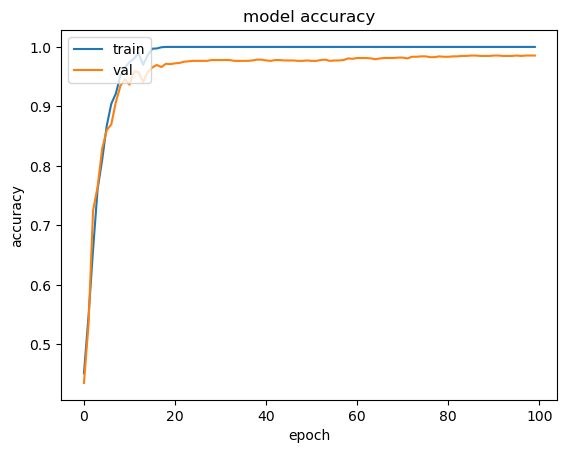

In [6]:
import pickle


with open('Results/98.5accModelHistory.pkl', 'rb') as f:
    history = pickle.load(f)


plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Plotting loss function

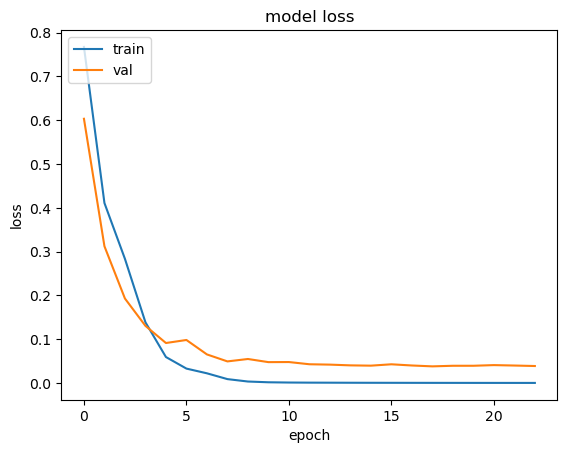

In [22]:
plt.plot(history['loss'][1:])
plt.plot(history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Making confusion matrix

In [27]:
import math
from sklearn import metrics
model.compute_metrics()

test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    


TypeError: compute_metrics() missing 4 required positional arguments: 'x', 'y', 'y_pred', and 'sample_weight'

Predicting single image

In [25]:
image_path = "Alzheimer_s Dataset/multiClassification/test/VeryMildDemented/file_2.jpg"

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

input_arr = input_arr.astype('float32') / 255.  # This is VERY important
predictions = model.predict(input_arr)

predicted_class = np.argmax(predictions, axis=-1)
predicted_class

1/1 [==============================] - 0s 243ms/step


array([1])

Exporting model

In [91]:
model.save('98.5accMulti.keras')